## **[:+:] -- Registration & Alignment for Neuroimagery -- [:+:]** 

In [2]:
from pystackreg import StackReg
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import glob
import tifffile as tif
import numpy as np
import scipy.io 
from scipy.io import loadmat
import os 
import imageio 
import sys
import image_registration as imreg
import seaborn as sb
import pandas as pd
# print(sys.path)
#import cv2
# import sys
# print(sys.path)


# [+]- Load .MAT file, decide output directory of resulting TIFF files
# matFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.mat")

unalignedFile180_300_refPrefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned180_300_refPrefix.tiff")
unalignedFile180_300_noPrefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned180_300_noPrefix.tiff")
matPath = (r'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files') 
refMouseFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNSx180_300.tiff")
samplePath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample")
tiffPath = (r'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_files') 
tiffFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.tiff")
subStackPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks")
subStackPath1= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks\p1")
superStackPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks")
registeredPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered")


psr_avgFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg180_300.tiff")
psr_avgTotalFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avgTotal.tiff")
psr_movAvg60File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg60.tiff")
psr_movAvg120File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg120.tiff")
psr_prevFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_prev.tiff")
psr_firstFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_firstFrame.tiff")
dft_avgFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\dft_avgTensor.tiff")

psr_avg_AFFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_AF.tiff")
psr_avgTotal_AFFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avgTotal_AF.tiff")
psr_movAvg60_AFFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg60_AF.tiff")
psr_movAvg120_AFFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg120_AF.tiff")
psr_prev_AFFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_prev_AF.tiff")
psr_first_AFFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_firstFrame_AF.tiff")


psr_avg_SRFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_SR.tiff")
psr_avgTotal_SRFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avgTotal_SR.tiff")
psr_movAvg60_SRFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg60_SR.tiff")
psr_movAvg120_SRFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg120_SR.tiff")
psr_prev_SRFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_prev_SR.tiff")
psr_first_SRFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_firstFrame_SR.tiff")


psr_avg_BLFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_BL.tiff")
psr_avgTotal_BLFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avgTotal_BL.tiff")
psr_movAvg60_BLFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg60_BL.tiff")
psr_movAvg120_BLFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_movAvg120_BL.tiff")
psr_first_BLFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_firstFrame_BL.tiff")



#unaligned180_300_noPrefix= io.imread(unalignedFile180_300_noPrefix)
unaligned180_300= io.imread(unalignedFile180_300_refPrefix)[:, :, 120:]
vLen= unaligned180_300.shape[2]
refMean = np.mean(io.imread(refMouseFile), axis=2)
std_Unaligned= np.std(unaligned180_300, axis= 2)

psr_avgTensor= io.imread(psr_avgFile)[:, :, 120:]
psr_avgTotal= io.imread(psr_avgTotalFile)
psr_movAvg60= io.imread(psr_movAvg60File)
psr_movAvg120= io.imread(psr_movAvg120File)[:, :, 120:]
psr_prev= io.imread(psr_prevFile)
psr_firstFrame= io.imread(psr_firstFile)

std_psr_avgTensor= np.std(psr_avgTensor, axis= 2)
std_psr_avgTotal= np.std(psr_avgTotal, axis= 2)
std_psr_movAvg60= np.std(psr_movAvg60, axis= 2)
std_psr_movAvg120= np.std(psr_movAvg120, axis= 2)
std_psr_prev= np.std(psr_prev, axis= 2)
std_psr_firstFrame= np.std(psr_firstFrame, axis= 2)


psr_avgTensor_AF= io.imread(psr_avg_AFFile)
psr_avgTotal_AF= io.imread(psr_avgTotal_AFFile)
psr_movAvg60_AF= io.imread(psr_movAvg60_AFFile)
psr_movAvg120_AF= io.imread(psr_movAvg120_AFFile)
psr_prev_AF= io.imread(psr_prev_AFFile)
psr_firstFrame_AF= io.imread(psr_first_AFFile)

std_psr_avgTensor_AF= np.std(psr_avgTensor_AF, axis= 2)
std_psr_avgTotal_AF= np.std(psr_avgTotal_AF, axis= 2)
std_psr_movAvg60_AF= np.std(psr_movAvg60_AF, axis= 2)
std_psr_movAvg120_AF= np.std(psr_movAvg120_AF, axis= 2)
std_psr_prev_AF= np.std(psr_prev_AF, axis= 2)
std_psr_firstFrame_AF= np.std(psr_firstFrame_AF, axis= 2)


psr_avgTensor_SR= io.imread(psr_avg_SRFile)
psr_avgTotal_SR= io.imread(psr_avgTotal_SRFile)
psr_movAvg60_SR= io.imread(psr_movAvg60_SRFile)
psr_movAvg120_SR= io.imread(psr_movAvg120_SRFile)
psr_prev_SR= io.imread(psr_prev_SRFile)
psr_firstFrame_SR= io.imread(psr_first_SRFile)

std_psr_avgTensor_SR= np.std(psr_avgTensor_SR, axis= 2)
std_psr_avgTotal_SR= np.std(psr_avgTotal_SR, axis= 2)
std_psr_movAvg60_SR= np.std(psr_movAvg60_SR, axis= 2)
std_psr_movAvg120_SR= np.std(psr_movAvg120_SR, axis= 2)
std_psr_prev_SR= np.std(psr_prev_SR, axis= 2)
std_psr_firstFrame_SR= np.std(psr_firstFrame_SR, axis= 2)


# psr_avgTensor_BL= io.imread(psr_avg_BLFile)
# psr_avgTotal_BL= io.imread(psr_avgTotal_BLFile)
# psr_movAvg60_BL= io.imread(psr_movAvg60_BLFile)
# psr_movAvg120_BL= io.imread(psr_movAvg120_BLFile)
# psr_firstFrame_BL= io.imread(psr_first_BLFile)

# std_psr_avgTensor_BL= np.std(psr_avgTensor_BL, axis= 2)
# std_psr_avgTotal_BL= np.std(psr_avgTotal_BL, axis= 2)
# std_psr_movAvg60_BL= np.std(psr_movAvg60_BL, axis= 2)
# std_psr_movAvg120_BL= np.std(psr_movAvg120_BL, axis= 2)
# std_psr_firstFrame_BL= np.std(psr_firstFrame_BL, axis= 2)

## __[+]__ Pre-Processing

In [3]:
def tensorize(filename, beginDex=0):
    if os.path.isfile(filename):
        baseName = os.path.basename(filename)
        if baseName.endswith('.mat'): 
            print("\n[::] --- Fields of the MAT file: --- " + str(filename))
            filename= loadmat(filename)
            vTensor = filename['MouseData']
            print(filename.keys())
            print("Header: " + str(filename['__header__']))
            print("Version: " + str(filename['__version__']))
            print("Globals: " + str(filename['__globals__']))
            print("[::] --- Type and dimensions of MAT img data: ")
            print(type(vTensor))
            print((vTensor.shape))
            print("Elements of type: " + str(type(vTensor[0][0][0])))
            print((vTensor[0][0][0+beginDex]))
            print((vTensor[1][1][1+beginDex]))
            print((vTensor[2][2][2+beginDex]))
        elif baseName.endswith('.tiff'):
            print("\n[::] --- Type and dimensions of TIFF File: --- " + str(filename))
            filename= io.imread(filename)
            print(type(filename))
            shape= filename.shape
            print("Shape: " + str(shape))
            if len(shape)==3 :
                print("Elements of type: " + str(type(filename[0][0][0])))
                print((filename[0][0][0]))
                print((filename[1][1][1]))
                print((filename[2][2][2]))
            else: 
                print("Elements of type: " + str(type(filename[0][0])))
                print((filename[0][0]))
                print((filename[1][1]))
                print((filename[2][2]))
        else: print("\nInvalid File type, no tensorInfo")
    elif isinstance(filename, np.ndarray):
        print("\n[::] --- Type and dimensions of Tensor: --- " )
        shape= filename.shape
        print("Shape: " + str(shape))
        if len(shape)==3 :
            print("Elements of type: " + str(type(filename[0][0][0])))
            print((filename[0][0][0]))
            print((filename[1][1][1]))
            print((filename[2][2][2]))
        else: 
            print("Elements of type: " + str(type(filename[0][0])))
            print((filename[0][0]))
            print((filename[1][1]))
            print((filename[2][2]))
    else: print("\nNo tensorInfo, Invalid Input")



def mattotiff(matFile, outPath, beginDex=0, enDex=3600, showTensorInfo=False, addendum=""):
    matData= loadmat(matFile)
    vTensor = matData['MouseData']

    # [+]- Specify a subset of the video frame tensor
    vTensor= vTensor[:, :, beginDex:enDex]

    # [+]- Save 3d tensor as a tiff image stack, saves into current directory by default
    matBaseName = os.path.basename(matFile)
    tiffName = os.path.splitext(matBaseName)[0] + addendum+".tiff"
    output_filename = os.path.join(outPath, tiffName)
    tif.imsave(output_filename, vTensor, bigtiff=True)

    #[+]- Access the new  TIFF file, and makes sure its dimensions are proper
    if showTensorInfo:
        print("matFile: " + matFile)
        print("matBaseName: " + matBaseName)
        print("tiffName: " + tiffName)
        print("output_filename: " + output_filename)
        tensorize(matFile, beginDex)
        tensorize((output_filename, beginDex))
    return output_filename


## __[+]__ Helper Functions

In [39]:
def euclidistance(a, b):
    # Make sure a and b have the same shape
    assert a.shape == b.shape
    # Calculate the difference between the two arrays element-wise
    diff = a - b
    # [+] Euclidean distance = frobenius norm of the sum of squared differences
    distance = np.linalg.norm(diff)
    return distance

def slice_n_Dice(mat1, mat2):
    assert mat2.shape == mat1.shape
    intersection = np.sum(mat1 * mat2)
    union = np.sum(mat1) + np.sum(mat2)
    dice = (2 * intersection) / union
    return dice

def distanceMatrix(vTensor, fMatrix,  endex, begindex=0):
    eDists= np.empty(0)
    diceSims= np.empty(0)
    for i in range(begindex, endex):
        eDist= euclidistance((vTensor[:, :, i]), fMatrix)
        eDists= np.append(eDists, eDist)

        diceSim= slice_n_Dice((vTensor[:, :, i]), fMatrix)
        diceSims= np.append(diceSims, diceSim)
    return eDists, diceSims


def DFTreg(vTensor, fMatrix,  endex, begindex=0):
    dft_avgTensor =np.reshape(fMatrix, (fMatrix.shape[0], fMatrix.shape[1], 1))
    offsets= np.empty(0)
    for i in range(begindex, endex):
        imReg= imreg.register_images(fMatrix, (vTensor[:, :, i]), return_registered=True )
        alignedMat= np.reshape(imReg[2], (imReg[2].shape[0], imReg[2].shape[1], 1))
        dft_avgTensor= np.concatenate((dft_avgTensor, alignedMat), axis=2)
        offDist= np.sqrt( imReg[0]**2 + imReg[1]**2)
        offsets= np.append(offsets, offDist )
    return dft_avgTensor, offsets

## __[+]:.__ Process .MAT Reference Files

In [ ]:
# [+]- Find the reference MAT file, convert it into a TIFF img stack, then extract the substack
#tiffRef= mat_to_tiff(matFile, outPath=samplePath, showTensorInfo= True)
# refFile100= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=0, enDex=100, showTensorInfo= True, addendum= "x100")
# refFile200= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=0, enDex=200, showTensorInfo= True, addendum= "x200")
# refFile300= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=0, enDex=300, showTensorInfo= True, addendum= "x300")
refFile180_300= mattotiff(matFile= refMouseFile, outPath= samplePath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")

## **[+]** Convert Entire Directory .MAT ->.TIFF 

In [18]:
# Get a list of all files in the directory
matFiles = [f for f in os.listdir(matPath) if os.path.isfile(os.path.join(matPath, f))]
# Print the number of files
print(f"Number of files in directory '{matPath}': {len(matFiles)}") 

# [+]- Iterate through directory of MAT files, converting each one into TIFF files:
for filename in matFiles:
    if filename.endswith('.mat'): 
        # print(filename)
        mattotiff(os.path.join(matPath, filename), outPath=tiffPath, beginDex=180, enDex=300, showTensorInfo= False, addendum= "x180_300")

Number of files in directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files': 82


#### __[+]__ Confirm Conversion

In [36]:
tiffFiles = [file for file in os.listdir(tiffPath) if os.path.isfile(os.path.join(tiffPath, file))]
print(f"Number of files in matPath directory '{matPath}': {len(matFiles)}")
print(f"Number of files in tiffPath directory '{tiffPath}': {len(tiffFiles)}")
for i in np.array([1,2,3,5,7,9]):
    print("\n[:::] ====================================================================================================================[::]")
    tensorize(os.path.join(matPath, matFiles[i]), beginDex= 180)
    tensorize(os.path.join(tiffPath, tiffFiles[i]), beginDex= 0)

Number of files in matPath directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files': 82
Number of files in tiffPath directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_files': 82

[:::] ====================================================================================================================[::]

[::] --- Fields of the MAT file: --- C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files\Norm_Mouse102_Stheta.mat
dict_keys(['__header__', '__version__', '__globals__', 'MouseData'])
Header: b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb  9 20:54:59 2023'
Version: 1.0
Globals: []
[::] --- Type and dimensions of MAT img data: 
<class 'numpy.ndarray'>
(128, 91, 3600)
Elements of type: <class 'numpy.float64'>
0.0676950693157897
0.08363135231643903
0.07697382520269894

[::] --- Type and dimensions of TIFF File: --- C:\Users\richa\

## __[+]__ Tensor Compilation

In [50]:
#[:+]- Compile the Tensor to be aligned -----[:]--- Put the reference substack in the right folder-----------------------------------------------//
tensorFrames= io.imread(refMouseFile)


#[:]--- Start with the reference frames, and append a directory of TIFF files onto it
for filename in glob.glob(subStackPath + '\*.tiff'):
    img= io.imread(filename)
    tensorFrames= np.concatenate((tensorFrames, img), axis=2)
    print( str(os.path.basename(filename))+ " ---> " + str(tensorFrames.shape))



#[:+]- Save the resulting unregistered tensor, will need later ----------------------------//
unalignedFile180_300= os.path.join(superStackPath,"unaligned180_300_refPrefix.tiff")
tif.imsave(unalignedFile180_300, tensorFrames)


#[+]- Save a version WITHOUT the reference appended at the beginning, for different registration methods
unalignedFile180_300= os.path.join(superStackPath,"unaligned180_300_noPrefix.tiff")
tif.imsave(unalignedFile180_300, tensorFrames[:, :, 120:])


unprefixed= io.imread(unalignedFile180_300_noPrefix)
prefixed= io.imread(unalignedFile180_300_refPrefix)



#[:+]- -----------Sanity Check ----------------------------------------------------//
#[:]- These should be equivalent:
tensorize(refMouseFile, beginDex= 0)
tensorize(prefixed[:, :, 0:120], beginDex= 0)

#[:]- These should be equivalent:
tensorize(prefixed[:, :, 120:], beginDex= 0)
tensorize(unprefixed, beginDex=0)

Norm_Mouse100_MKNSx180_300.tiff ---> (128, 91, 240)
Norm_Mouse102_Sthetax180_300.tiff ---> (128, 91, 360)
Norm_Mouse104_MKthetax180_300.tiff ---> (128, 91, 480)
Norm_Mouse105_Sthetax180_300.tiff ---> (128, 91, 600)
Norm_Mouse106_SNSx180_300.tiff ---> (128, 91, 720)
Norm_Mouse107_MKthetax180_300.tiff ---> (128, 91, 840)
Norm_Mouse108_Sthetax180_300.tiff ---> (128, 91, 960)
Norm_Mouse109_MKgammax180_300.tiff ---> (128, 91, 1080)
Norm_Mouse110_Sgammax180_300.tiff ---> (128, 91, 1200)
Norm_Mouse111_Sthetax180_300.tiff ---> (128, 91, 1320)
Norm_Mouse112_Sthetax180_300.tiff ---> (128, 91, 1440)
Norm_Mouse113_Sgammax180_300.tiff ---> (128, 91, 1560)
Norm_Mouse114_SNSx180_300.tiff ---> (128, 91, 1680)
Norm_Mouse115_SNSx180_300.tiff ---> (128, 91, 1800)
Norm_Mouse116_Sgammax180_300.tiff ---> (128, 91, 1920)
Norm_Mouse117_Sthetax180_300.tiff ---> (128, 91, 2040)
Norm_Mouse118_MKgammax180_300.tiff ---> (128, 91, 2160)
Norm_Mouse119_SNSx180_300.tiff ---> (128, 91, 2280)
Norm_Mouse120_Sthetax180_30

## __[+:]__ Referencing Methods

#### __[+]__ Initialize for Registration

In [5]:
registrarRB = StackReg(StackReg.RIGID_BODY)
registrarSR = StackReg(StackReg.SCALED_ROTATION)
registrarAF = StackReg(StackReg.AFFINE)
registrarBL = StackReg(StackReg.BILINEAR)
unaligned180_300_refPrefix= io.imread(unalignedFile180_300_refPrefix)
unaligned180_300_noPrefix= io.imread(unalignedFile180_300_refPrefix)[:, :, 120:]
# unaligned180_300_noPrefix= io.imread(unalignedFile180_300_noPrefix)

#### __[+]__ Register to Previous Frame

In [4]:
#[:+:]--- -----------------------------------Choose Referencing Method  ------------------------------------------------------------------------------//
#[ ]-  this option registers each frame to the previous (already registered) one
psr_prev = registrarRB.register_transform_stack(unaligned180_300_noPrefix, reference='previous')
outPath= os.path.join(registeredPath,"psr_prev.tiff")
tif.imsave(outPath, psr_prev)
psr_prev= io.imread(outPath)
tensorize(psr_prev)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.08659610152244568
0.07894855737686157


#### __[+]__ Rigid Body Registration: to First Image

In [19]:
#[ ]-  this option registers to first image:
psr_firstFrame = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first')[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_firstFrame.tiff")
tif.imsave(outPath, psr_firstFrame)
psr_firstFrame= io.imread(outPath)
tensorize(psr_firstFrame)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.08556574583053589
0.08372913300991058


#### __[+]__ Rigid Body Registration: the Total Mean

In [47]:
#[ ]-  this option registers to mean image:
psr_mean = registrarRB.register_transform_stack(unaligned180_300_noPrefix, reference='mean')
outPath= os.path.join(registeredPath,"psr_avgTotal.tiff")
tif.imsave(outPath, psr_mean)
psr_avgTotal= io.imread(outPath)
tensorize(psr_avgTotal)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.04614986479282379
0.06338934600353241
0.06866535544395447


#### __[+]__ Rigid Body Registration: Mean of First n images

In [6]:
# [+]-  this option registers to mean of first n_frames(300-180=120) images:
psr_avg180_300 = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)
# [:+:]---  Saving the results  --------------------------------------------------//
# [-]- To save the output to a tiff stack image, first convert float values to int
#   [+]- Actually doesn't seem necessary, float64 works
# psr_avg180_300 = psr_avg180_300.astype(np.int8)

# Using tifffile to save one of the image stacks into a single tif
alignedImgFile180_300= os.path.join(registeredPath,"psr_avg180_300.tiff")
tif.imsave(alignedImgFile180_300, psr_avg180_300)
rez= io.imread(alignedImgFile180_300)
tensorize(rez)

#### __[+]__ Rigid Body Registration: Moving Average

In [43]:
# calculate a moving average of n_frames images, then register the moving average to the mean of the first x images and transform the original image (not the moving average)
# windowSize= 60
# psr_movAvg60 = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)
# outPath= os.path.join(registeredPath,"psr_movAvg60.tiff")
# tif.imsave(outPath, psr_movAvg60)
# rez= io.imread(outPath)
# tensorize(rez)

windowSize= 120
psr_movAvg120 = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)
outPath= os.path.join(registeredPath,"psr_movAvg120.tiff")
tif.imsave(outPath, psr_movAvg120)
psr_movAvg120= io.imread(outPath)
tensorize(psr_movAvg120)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9960)
Elements of type: <class 'numpy.float64'>
0.06249745935201645
0.08422132581472397
0.08067630976438522


#### __[ ]__ DFT Registration  + Chi2Shift Error

In [40]:
dft_mean= DFTreg(unaligned180_300_noPrefix, refMean,  endex=vLen, begindex= 0)
dft_avgTensor= dft_mean[0]
dft_chiSq= dft_mean[1]
outPath= os.path.join(registeredPath,"dft_avgTensor.tiff")
tif.imsave(outPath, dft_avgTensor)
dft_avgTensor= io.imread(outPath)
tensorize(dft_avgTensor)

KeyboardInterrupt: 

#### __[+]__ Affine Registration

In [ ]:
psr_avg_AF = registrarAF.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_AF.tiff")
tif.imsave(outPath, psr_avg_AF)
psr_avg_AF= io.imread(outPath)
tensorize(psr_avg_AF)

#[ ]-   Moving window affine
windowSize= 60
psr_movAvg60_AF = registrarAF.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_movAvg60_AF.tiff")
tif.imsave(outPath, psr_movAvg60_AF)
rez= io.imread(outPath)
tensorize(rez)


windowSize= 120
psr_movAvg60_AF = registrarAF.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_movAvg120_AF.tiff")
tif.imsave(outPath, psr_movAvg60_AF)
rez= io.imread(outPath)
tensorize(rez)

#[ ]-  this option registers to mean image:
psr_mean_AF = registrarAF.register_transform_stack(unaligned180_300_noPrefix, reference='mean')
outPath= os.path.join(registeredPath,"psr_avgTotal_AF.tiff")
tif.imsave(outPath, psr_mean_AF)
psr_avgTotal_AF= io.imread(outPath)
tensorize(psr_avgTotal_AF)

#[ ]-  this option registers each frame to the previous (already registered) one
psr_prev_AF = registrarAF.register_transform_stack(unaligned180_300_noPrefix, reference='previous')
outPath= os.path.join(registeredPath,"psr_prev_AF.tiff")
tif.imsave(outPath, psr_prev_AF)
psr_prev_AF= io.imread(outPath)
tensorize(psr_prev_AF)

psr_firstFrame_AF = registrarAF.register_transform_stack(unaligned180_300_refPrefix, reference='first')[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_firstFrame_AF.tiff")
tif.imsave(outPath, psr_firstFrame_AF)
psr_firstFrame_AF= io.imread(outPath)
tensorize(psr_firstFrame_AF)

#### __[+]__ Scaled Rotation Registration

In [56]:
psr_avg_SR = registrarSR.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_SR.tiff")
tif.imsave(outPath, psr_avg_SR)
psr_avg_SR= io.imread(outPath)
tensorize(psr_avg_SR)

#[ ]-   Moving window SRfine
windowSize= 60
psr_movAvg60_SR = registrarSR.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_movAvg60_SR.tiff")
tif.imsave(outPath, psr_movAvg60_SR)
rez= io.imread(outPath)
tensorize(rez)


windowSize= 120
psr_movAvg60_SR = registrarSR.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_movAvg120_SR.tiff")
tif.imsave(outPath, psr_movAvg60_SR)
rez= io.imread(outPath)
tensorize(rez)

#[ ]-  this option registers to mean image:
psr_mean_SR = registrarSR.register_transform_stack(unaligned180_300_noPrefix, reference='mean')
outPath= os.path.join(registeredPath,"psr_avgTotal_SR.tiff")
tif.imsave(outPath, psr_mean_SR)
psr_avgTotal_SR= io.imread(outPath)
tensorize(psr_avgTotal_SR)

#[ ]-  this option registers each frame to the previous (already registered) one
psr_prev_SR = registrarSR.register_transform_stack(unaligned180_300_noPrefix, reference='previous')
outPath= os.path.join(registeredPath,"psr_prev_SR.tiff")
tif.imsave(outPath, psr_prev_SR)
psr_prev_SR= io.imread(outPath)
tensorize(psr_prev_SR)

psr_firstFrame_SR = registrarSR.register_transform_stack(unaligned180_300_refPrefix, reference='first')[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_firstFrame_SR.tiff")
tif.imsave(outPath, psr_firstFrame_SR)
psr_firstFrame_SR= io.imread(outPath)
tensorize(psr_firstFrame_SR)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.06262659281492233
0.06930050998926163

[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.04578757658600807
0.06911810487508774
0.060942910611629486

[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.052005164325237274
0.07533953338861465
0.07056960463523865

[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.04626870155334473
0.06432881951332092
0.06922341883182526

[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.08554665744304657
0.07836540788412094

[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.0855686

#### __[+]__ Bilinear Registration

In [4]:
psr_avg_BL = registrarBL.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_BL.tiff")
tif.imsave(outPath, psr_avg_BL)
psr_avg_BL= io.imread(outPath)
tensorize(psr_avg_BL)

#[ ]-   Moving window BLfine
windowSize= 60
psr_movAvg60_BL = registrarBL.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_movAvg60_BL.tiff")
tif.imsave(outPath, psr_movAvg60_BL)
rez= io.imread(outPath)
tensorize(rez)


windowSize= 120
psr_movAvg60_BL = registrarBL.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_movAvg120_BL.tiff")
tif.imsave(outPath, psr_movAvg60_BL)
rez= io.imread(outPath)
tensorize(rez)

#[ ]-  this option registers to mean image:
psr_mean_BL = registrarBL.register_transform_stack(unaligned180_300_noPrefix, reference='mean')
outPath= os.path.join(registeredPath,"psr_avgTotal_BL.tiff")
tif.imsave(outPath, psr_mean_BL)
psr_avgTotal_BL= io.imread(outPath)
tensorize(psr_avgTotal_BL)

psr_firstFrame_BL = registrarBL.register_transform_stack(unaligned180_300_refPrefix, reference='first')[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_firstFrame_BL.tiff")
tif.imsave(outPath, psr_firstFrame_BL)
psr_firstFrame_BL= io.imread(outPath)
tensorize(psr_firstFrame_BL)

NameError: name 'registrarBL' is not defined

## __[+]__ Heuristics

In [13]:
#[:]-- Create the distance matrices
unaligned_DM= (distanceMatrix(unaligned180_300, refMean, endex=vLen, begindex= 0))
psr_refAvg_DM= (distanceMatrix(psr_avgTensor, refMean, endex=vLen, begindex= 0))
psr_avgTotal_DM= (distanceMatrix(psr_avgTotal, refMean, endex=vLen, begindex= 0))
psr_movAvg60_DM= (distanceMatrix(psr_movAvg60, refMean, endex=vLen, begindex= 0))
psr_movAvg120_DM= (distanceMatrix(psr_movAvg120, refMean, endex=vLen, begindex= 0))
psr_prev_DM= (distanceMatrix(psr_prev, refMean, endex=vLen, begindex= 0))
psr_first_DM= (distanceMatrix(psr_firstFrame, refMean, endex=vLen, begindex= 0))

In [11]:
psr_refAvg_AF_DM= (distanceMatrix(psr_avgTensor_AF, refMean, endex=vLen, begindex= 0))
psr_avgTotal_AF_DM= (distanceMatrix(psr_avgTotal_AF, refMean, endex=vLen, begindex= 0))
psr_movAvg60_AF_DM= (distanceMatrix(psr_movAvg60_AF, refMean, endex=vLen, begindex= 0))
psr_movAvg120_AF_DM= (distanceMatrix(psr_movAvg120_AF, refMean, endex=vLen, begindex= 0))
psr_prev_AF_DM= (distanceMatrix(psr_prev_AF, refMean, endex=vLen, begindex= 0))
psr_first_AF_DM= (distanceMatrix(psr_firstFrame_AF, refMean, endex=vLen, begindex= 0))

In [12]:
psr_refAvg_SR_DM= (distanceMatrix(psr_avgTensor_SR, refMean, endex=vLen, begindex= 0))
psr_avgTotal_SR_DM= (distanceMatrix(psr_avgTotal_SR, refMean, endex=vLen, begindex= 0))
psr_movAvg60_SR_DM= (distanceMatrix(psr_movAvg60_SR, refMean, endex=vLen, begindex= 0))
psr_movAvg120_SR_DM= (distanceMatrix(psr_movAvg120_SR, refMean, endex=vLen, begindex= 0))
psr_prev_SR_DM= (distanceMatrix(psr_prev_SR, refMean, endex=vLen, begindex= 0))
psr_first_SR_DM= (distanceMatrix(psr_firstFrame_SR, refMean, endex=vLen, begindex= 0))

In [2]:
psr_refAvg_BL_DM= (distanceMatrix(psr_avgTensor_BL, refMean, endex=vLen, begindex= 0))
psr_avgTotal_BL_DM= (distanceMatrix(psr_avgTotal_BL, refMean, endex=vLen, begindex= 0))
psr_movAvg60_BL_DM= (distanceMatrix(psr_movAvg60_BL, refMean, endex=vLen, begindex= 0))
psr_movAvg120_BL_DM= (distanceMatrix(psr_movAvg120_BL, refMean, endex=vLen, begindex= 0))
psr_first_BL_DM= (distanceMatrix(psr_firstFrame_BL, refMean, endex=vLen, begindex= 0))

NameError: name 'distanceMatrix' is not defined

### __[:]__ -- RigidBody

In [ ]:
# print(std_Unaligned)
print(unaligned180_300.shape)
print(psr_avgTensor.shape)
print(refMean.shape)
print("\n")

print(std_Unaligned.shape)
print(std_psr_avgTensor.shape)
print(std_psr_avgTotal.shape)
print(std_psr_movAvg60.shape)
print(std_psr_movAvg120.shape)
print(std_psr_prev.shape)
print(std_psr_firstFrame.shape)
print("\n")

print(np.sum(std_Unaligned))
print(np.sum(std_psr_avgTensor))
print(np.sum(std_psr_avgTotal))
print(np.sum(std_psr_movAvg60))
print(np.sum(std_psr_movAvg120))
print(np.sum(std_psr_prev))
print(np.sum(std_psr_firstFrame))
print("\n")

print(psr_refAvg_DM[0:2])
print(psr_avgTotal_DM[0:2])
print(psr_movAvg60_DM[0:2])
print(psr_movAvg120_DM[0:2])
print(psr_prev_DM[0:2])
print(psr_first_DM[0:2])

### __[:]__ -- Affine: 

In [ ]:
print(unaligned180_300.shape)
print(psr_avgTensor.shape)
print(refMean.shape)
print("\n")

print(std_Unaligned.shape)
print(std_psr_avgTensor_AF.shape)
print(std_psr_avgTotal_AF.shape)
print(std_psr_movAvg60_AF.shape)
print(std_psr_movAvg120_AF.shape)
print(std_psr_prev_AF.shape)
print(std_psr_firstFrame_AF.shape)
print("\n")

print(np.sum(std_Unaligned))
print(np.sum(std_psr_avgTensor_AF))
print(np.sum(std_psr_avgTotal_AF))
print(np.sum(std_psr_movAvg60_AF))
print(np.sum(std_psr_movAvg120_AF))
print(np.sum(std_psr_prev_AF))
print(np.sum(std_psr_firstFrame_AF))
print("\n")

print(psr_refAvg_AF_DM[0:2])
print(psr_avgTotal_AF_DM[0:2])
print(psr_movAvg60_AF_DM[0:2])
print(psr_movAvg120_AF_DM[0:2])
print(psr_prev_AF_DM[0:2])
print(psr_first_AF_DM[0:2])

### __[:]__ -- Scale Rotation: 

In [ ]:
print(unaligned180_300.shape)
print(psr_avgTensor.shape)
print(refMean.shape)
print("\n")

print(std_Unaligned.shape)
print(std_psr_avgTensor_SR.shape)
print(std_psr_avgTotal_SR.shape)
print(std_psr_movAvg60_SR.shape)
print(std_psr_movAvg120_SR.shape)
print(std_psr_prev_SR.shape)
print(std_psr_firstFrame_SR.shape)
print("\n")

print(np.sum(std_Unaligned))
print(np.sum(std_psr_avgTensor_SR))
print(np.sum(std_psr_avgTotal_SR))
print(np.sum(std_psr_movAvg60_SR))
print(np.sum(std_psr_movAvg120_SR))
print(np.sum(std_psr_prev_SR))
print(np.sum(std_psr_firstFrame_SR))
print("\n")

print(psr_refAvg_SR_DM[0:2])
print(psr_avgTotal_SR_DM[0:2])
print(psr_movAvg60_SR_DM[0:2])
print(psr_movAvg120_SR_DM[0:2])
print(psr_prev_SR_DM[0:2])
print(psr_first_SR_DM[0:2])

### __[:]__ -- Bilinear: 

In [ ]:
print(unaligned180_300.shape)
print(psr_avgTensor.shape)
print(refMean.shape)
print("\n")

print(std_Unaligned.shape)
print(std_psr_avgTensor_BL.shape)
print(std_psr_avgTotal_BL.shape)
print(std_psr_movAvg60_BL.shape)
print(std_psr_movAvg120_BL.shape)
print(std_psr_firstFrame_BL.shape)
print("\n")

print(np.sum(std_Unaligned))
print(np.sum(std_psr_avgTensor_BL))
print(np.sum(std_psr_avgTotal_BL))
print(np.sum(std_psr_movAvg60_BL))
print(np.sum(std_psr_movAvg120_BL))
print(np.sum(std_psr_firstFrame_BL))
print("\n")

print(psr_refAvg_BL_DM[0:2])
print(psr_avgTotal_BL_DM[0:2])
print(psr_movAvg60_BL_DM[0:2])
print(psr_movAvg120_BL_DM[0:2])
print(psr_first_BL_DM[0:2])

## __[ ]__ Data Viz

### __[+]__ RigidBody

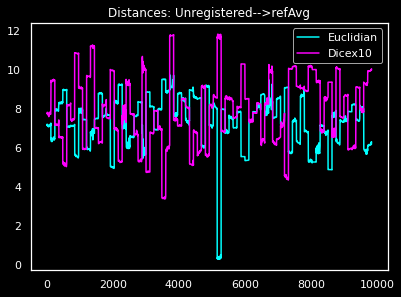

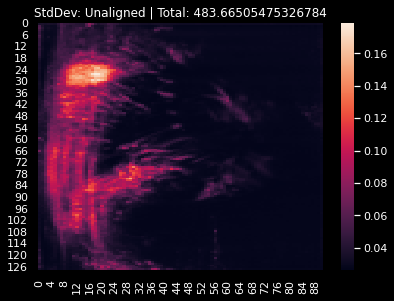

KeyboardInterrupt: 

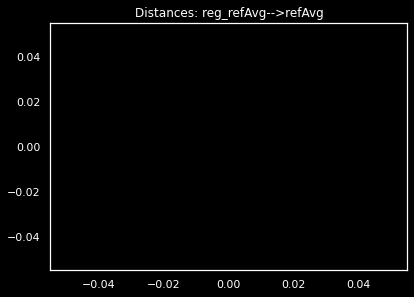

In [55]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .5

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: Unregistered-->refAvg')
sb.lineplot(x=np.arange(vLen), y=unaligned_DM[0], color= 'cyan', label= 'Euclidian')
sb.lineplot(x=np.arange(vLen), y=unaligned_DM[1]*100, color= 'magenta', label= 'Dicex10')
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('StdDev: Unaligned | Total: ' + str(np.sum(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: reg_refAvg-->refAvg')
sb.lineplot(x=np.arange(vLen), y=unaligned_DM[0], color= 'cyan', label= 'Euclidian')
sb.lineplot(x=np.arange(vLen), y=unaligned_DM[1]*100, color= 'magenta', label= 'Dicex10')
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTensor )
plt.title('StdDev: Registered to Reference Average | Total: ' + str(np.sum(std_psr_avgTensor)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: reg_totAvg-->refAvg')
sb.lineplot(x=np.arange(vLen), y=psr_avgTotal_DM[0], color= 'cyan', label= 'Euclidian' )
sb.lineplot(x=np.arange(vLen), y=psr_avgTotal_DM[1]*100, color= 'magenta', label= 'Dicex10')
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTotal )
plt.title('StdDev: Registered to Total Average | Total: ' + str(np.sum(std_psr_avgTotal)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: reg_movAvg60-->refAvg')
sb.lineplot(x=np.arange(vLen), y= psr_movAvg60_DM[0], color= 'cyan', label= " Euclidian" )
sb.lineplot(x=np.arange(vLen), y= psr_movAvg60_DM[1]*100, color= 'magenta', label= "Dice")
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg60 )
plt.title('StdDev: Registered to Moving Average of 60 Frames | Total: ' + str(np.sum(std_psr_movAvg60)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: reg_movAvg120-->refAvg')
sb.lineplot(x=np.arange(vLen), y= psr_movAvg120_DM[0], color= 'cyan', label= " Euclidian" )
sb.lineplot(x=np.arange(vLen), y= psr_movAvg120_DM[1]*100, color= 'magenta', label= "Dice")
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg120 )
plt.title('StdDev: Registered to Moving Average of 120 Frames | Total: ' + str(np.sum(std_psr_movAvg120)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: reg_firstFrame-->refAvg')
sb.lineplot(x=np.arange(vLen), y= psr_first_DM[0], color= 'cyan', label= " Euclidian" )
sb.lineplot(x=np.arange(vLen), y= psr_first_DM[1]*100, color= 'magenta', label= "Dice")
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_firstFrame )
plt.title('StdDev: Registered to First Frame | Total: ' + str(np.sum(std_psr_firstFrame)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Distances: reg_prev-->refAvg')
sb.lineplot(x=np.arange(vLen), y= psr_prev_DM[0], color= 'cyan', label= " Euclidian" )
sb.lineplot(x=np.arange(vLen), y= psr_prev_DM[1]*100, color= 'magenta', label= "Dice")
plt.legend()
plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_prev)
plt.title('StdDev: Registered to previous Frame | Total: ' + str(np.sum(std_psr_prev)))
plt.show()

### __[+]__ Affine

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .7

# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# plt.title('Distances: Unregistered-->refAvg')
# sb.lineplot(x=np.arange(vLen), y=unaligned_DM[0], color= 'cyan', label= 'Euclidian')
# sb.lineplot(x=np.arange(vLen), y=unaligned_DM[1]*100, color= 'magenta', label= 'Dicex10')
# plt.legend()
# plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('StdDev: Unaligned | Total: ' + str(np.sum(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTensor_AF )
plt.title('StdDev: Registered to Reference Average | Total: ' + str(np.sum(std_psr_avgTensor_AF)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTotal_AF )
plt.title('StdDev: Registered to Total Average | Total: ' + str(np.sum(std_psr_avgTotal_AF)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg60_AF )
plt.title('StdDev: Registered to Moving Average of 60 Frames | Total: ' + str(np.sum(std_psr_movAvg60_AF)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg120_AF )
plt.title('StdDev: Registered to Moving Average of 120 Frames | Total: ' + str(np.sum(std_psr_movAvg120_AF)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_firstFrame_AF )
plt.title('StdDev: Registered to First Frame | Total: ' + str(np.sum(std_psr_firstFrame_AF)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_prev_AF)
plt.title('StdDev: Registered to previous Frame | Total: ' + str(np.sum(std_psr_prev_AF)))
plt.show()

### __[+]__ Scale + Rotation

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .5

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('StdDev: Unaligned | Total: ' + str(np.sum(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTensor_SR )
plt.title('StdDev: Registered to Reference Average | Total: ' + str(np.sum(std_psr_avgTensor_SR)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTotal_SR )
plt.title('StdDev: Registered to Total Average | Total: ' + str(np.sum(std_psr_avgTotal_SR)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg60_SR )
plt.title('StdDev: Registered to Moving Average of 60 Frames | Total: ' + str(np.sum(std_psr_movAvg60_SR)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg120_SR )
plt.title('StdDev: Registered to Moving Average of 120 Frames | Total: ' + str(np.sum(std_psr_movAvg120_SR)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_firstFrame_SR )
plt.title('StdDev: Registered to First Frame | Total: ' + str(np.sum(std_psr_firstFrame_SR)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_prev_SR)
plt.title('StdDev: Registered to previous Frame | Total: ' + str(np.sum(std_psr_prev_SR)))
plt.show()

### __[+]__ Bilinear

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .7

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('StdDev: Unaligned | Total: ' + str(np.sum(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTensor_BL )
plt.title('StdDev: Registered to Reference Average | Total: ' + str(np.sum(std_psr_avgTensor_BL)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avgTotal_BL )
plt.title('StdDev: Registered to Total Average | Total: ' + str(np.sum(std_psr_avgTotal_BL)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg60_BL )
plt.title('StdDev: Registered to Moving Average of 60 Frames | Total: ' + str(np.sum(std_psr_movAvg60_BL)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_movAvg120_BL )
plt.title('StdDev: Registered to Moving Average of 120 Frames | Total: ' + str(np.sum(std_psr_movAvg120_BL)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_firstFrame_BL )
plt.title('StdDev: Registered to First Frame | Total: ' + str(np.sum(std_psr_firstFrame_BL)))
plt.show()

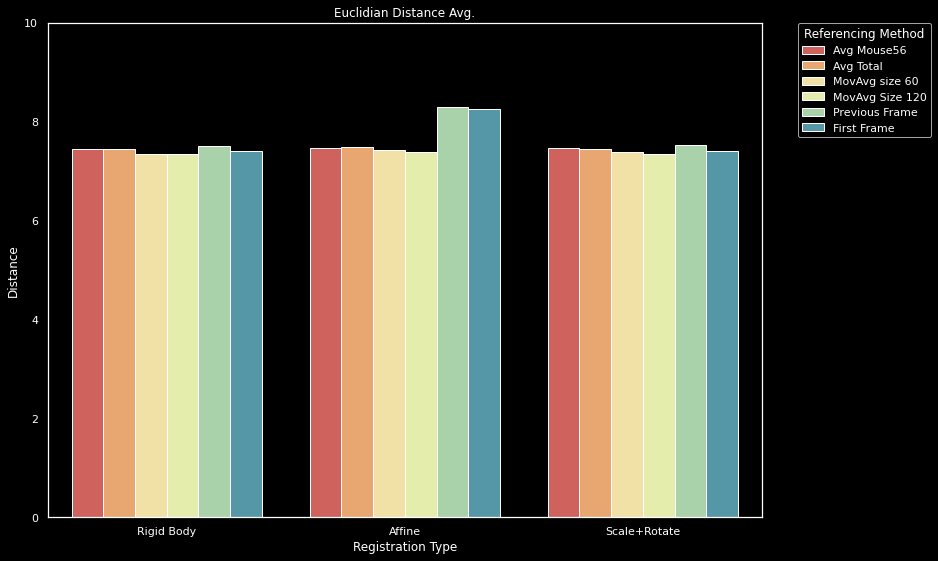

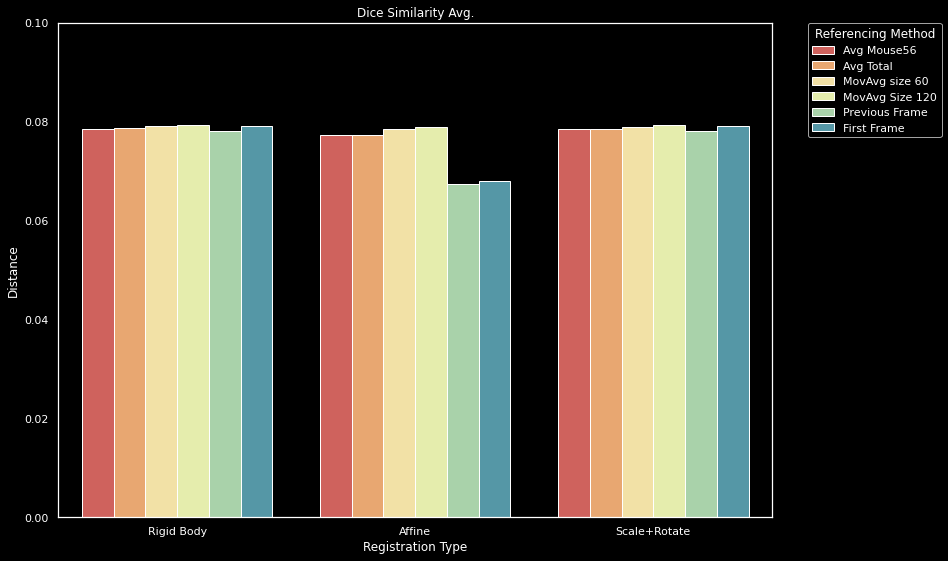

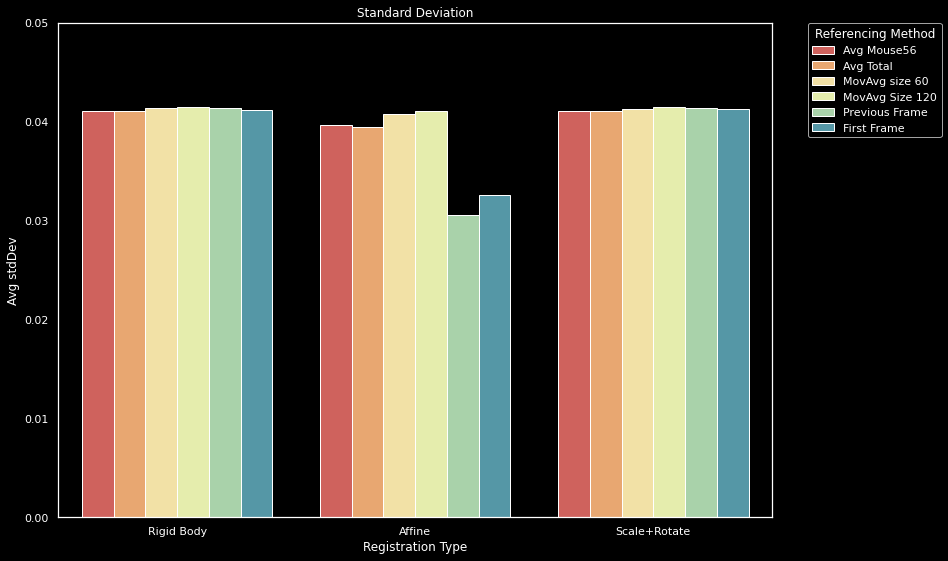

In [154]:
sizer= 1
unreg= unaligned_DM[0]

 
eucliDiction= {'barCluster': np.concatenate((['Rigid Body']*6, ['Affine']*6, ['Scale+Rotate']*6)),
        'clrCategory': ['Avg Mouse56', 'Avg Total', 'MovAvg size 60', 'MovAvg Size 120', 'Previous Frame', 'First Frame']*3,
        'EucliDistance': [
            np.mean(psr_refAvg_DM[0]), 
            np.mean(psr_avgTotal_DM[0]),
            np.mean(psr_movAvg60_DM[0]),
            np.mean(psr_movAvg120_DM[0]), 
            np.mean(psr_prev_DM[0]), 
            np.mean(psr_first_DM[0]),

            np.mean(psr_refAvg_AF_DM[0]), 
            np.mean(psr_avgTotal_AF_DM[0]),
            np.mean(psr_movAvg60_AF_DM[0]),
            np.mean(psr_movAvg120_AF_DM[0]), 
            np.mean(psr_prev_AF_DM[0]), 
            np.mean(psr_first_AF_DM[0]),

            np.mean(psr_refAvg_SR_DM[0]), 
            np.mean(psr_avgTotal_SR_DM[0]),
            np.mean(psr_movAvg60_SR_DM[0]),
            np.mean(psr_movAvg120_SR_DM[0]), 
            np.mean(psr_prev_SR_DM[0]), 
            np.mean(psr_first_SR_DM[0])
        ],
        'DiceSim': [
            np.mean(psr_refAvg_DM[1]), 
            np.mean(psr_avgTotal_DM[1]),
            np.mean(psr_movAvg60_DM[1]),
            np.mean(psr_movAvg120_DM[1]), 
            np.mean(psr_prev_DM[1]), 
            np.mean(psr_first_DM[1]),

            np.mean(psr_refAvg_AF_DM[1]), 
            np.mean(psr_avgTotal_AF_DM[1]),
            np.mean(psr_movAvg60_AF_DM[1]),
            np.mean(psr_movAvg120_AF_DM[1]), 
            np.mean(psr_prev_AF_DM[1]), 
            np.mean(psr_first_AF_DM[1]),

            np.mean(psr_refAvg_SR_DM[1]), 
            np.mean(psr_avgTotal_SR_DM[1]),
            np.mean(psr_movAvg60_SR_DM[1]),
            np.mean(psr_movAvg120_SR_DM[1]), 
            np.mean(psr_prev_SR_DM[1]), 
            np.mean(psr_first_SR_DM[1])
        ],
        # 'Tmp': np.arange(18)
}
eucliDataFrame = pd.DataFrame(eucliDiction)


stdDiction= {'barCluster': np.concatenate((['Rigid Body']*6, ['Affine']*6, ['Scale+Rotate']*6)),
        'clrCategory': ['Avg Mouse56', 'Avg Total', 'MovAvg size 60', 'MovAvg Size 120', 'Previous Frame', 'First Frame']*3,
        'std': [
            np.mean(std_psr_avgTensor), 
            np.mean(std_psr_avgTotal),
            np.mean(std_psr_movAvg60),
            np.mean(std_psr_movAvg120), 
            np.mean(std_psr_prev), 
            np.mean(std_psr_firstFrame),

            np.mean(std_psr_avgTensor_AF), 
            np.mean(std_psr_avgTotal_AF),
            np.mean(std_psr_movAvg60_AF),
            np.mean(std_psr_movAvg120_AF), 
            np.mean(std_psr_prev_AF), 
            np.mean(std_psr_firstFrame_AF),

            np.mean(std_psr_avgTensor_SR), 
            np.mean(std_psr_avgTotal_SR),
            np.mean(std_psr_movAvg60_SR),
            np.mean(std_psr_movAvg120_SR), 
            np.mean(std_psr_prev_SR), 
            np.mean(std_psr_firstFrame_SR)
        ],
}
stdDF = pd.DataFrame(stdDiction)



plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
barPlot= sb.barplot(x='barCluster', y='EucliDistance', 
           hue='clrCategory', 
           data= eucliDataFrame, 
        #    palette= 'colorblind', 
         #   palette= 'pastel'
           palette= 'Spectral'
           #order = ['Rigid Body','Affine','Scale+Rotation']
)
plt.ylim(0, 10) # adjust y-axis limits
barPlot.set(xlabel='Registration Type',ylabel='Distance', title='Euclidian Distance Avg.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= 'Referencing Method')
plt.show()


plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
barPlot= sb.barplot(x='barCluster', y='DiceSim', 
           hue='clrCategory', 
           data= eucliDataFrame, 
           palette= 'Spectral'
)
plt.ylim(0, .1) 
barPlot.set(xlabel='Registration Type',ylabel='Distance', title='Dice Similarity Avg.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= 'Referencing Method')
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
barPlot= sb.barplot(x='barCluster', y='std', 
           hue='clrCategory', 
           data= stdDF, 
           palette= 'Spectral'
)
plt.ylim(0, 0.05) 
barPlot.set(xlabel='Registration Type',ylabel='Avg stdDev', title='Standard Deviation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= 'Referencing Method')
plt.show()

## __[:::]__ ToDo

##### __[:+:]__--- Pre-processing ---
 - [+] Fix tiff files, they seem to be only 91x3600 instead of 91x128x3600
 - [+] Convert one ref MAT into TIFF
 - [+] Convert all 82 MATs into TIFFs
 - [+] Split single tiff file (sample) into first 100-300 frames
 - [+] Split whole data set into first 100-300 frames
 - [+] Change reference and substack to 180-300 frames
 - [+] save unaligned tiff 
##### __[::]__-- Alignment Algos (120-300) ---
 - [+] Pystackreg Align with reference avg
 - [+] Pystackreg ALign with moving window size 60
 - [+] Pystackreg ALign with total Average
 - [+] PSR previous frame
 - [+] PSR first frame
 - [+] Moving windows of multiple sizes
 - [+] Affine type registration
 - [+] Scaled Rotation type registration
 - [ ] Bilinear type registration
 - [ ] Combined Algos
 - [ ] ch^2 shift
 - [ ] cross-correlation shift
##### __[::]__-- Heuristics Functions ---
 - [x] Euclidian distance 
 - [x] Standard deviation
 - [x] Dice distance
 - [ ] Min & Max
 - [ ] Chi^2
 ##### __[::]__-- Data Viz ---
 - [+] Rigid Body Registration
 - [+] Animate pystackreg registered
 - [+] Affine type registration
 - [+] Scaled Rotation type registration
 - [+] Bilinear type registration


##### -[::]--- Misc ---
 - [+] Make Repo
 - [+] Form Functions
 - [+] Fix tensorInfo fx
 - [ ] Bar Graphs
 - [ ] Bar Graphs
 - [ ] Better Animations
 - [ ] Compare single images across different mice, and find the differences
 - [ ] Create DataFrame for plotting